# Btc Moving Average Trade Strategy

## Download and process the data

In [91]:
import json
import time
import sys
from datetime import datetime, timedelta
from urllib.request import Request, urlopen
from urllib.parse import urlencode
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import math as ma
import random
import statistics as stat

minute = 60
hour = minute*60
day = hour*24
week = day*7
month = day*30
year = day*365

# Possible Commands
PUBLIC_COMMANDS = [ 'returnTradeHistory', 'returnChartData','returnLoanOrders']

class Poloniex:
    def __init__(self):
        # Conversions
        self.timestamp_str = lambda timestamp=time.time(), format="%Y-%m-%d %H:%M:%S": datetime.fromtimestamp(timestamp).strftime(format)
        self.str_timestamp = lambda datestr=self.timestamp_str(), format="%Y-%m-%d %H:%M:%S": int(time.mktime(time.strptime(datestr, format)))
        self.float_roundPercent = lambda floatN, decimalP=2: str(round(float(floatN) * 100, decimalP))+"%"

        # PUBLIC COMMANDS
        
        self.marketChart = lambda pair, period, start=time.time()-(month*1), end=time.time(): self.api('returnChartData', {'currencyPair':pair, 'period':period, 'start':start, 'end':end})
        
        # the marketTradeHist data is before 2 days from today
        
        self.marketTradeHist = lambda pair, start=time.time()-(day*2), end=time.time(): self.api('returnTradeHistory',{'currencyPair':pair, 'start':start, 'end':end}) # NEEDS TO BE FIXED ON Poloniex
        self.marketLoans = lambda coin: self.api('returnLoanOrders',{'currency':coin})
        
    #####################
    # Main Api Function #
    #####################
    def api(self, command, args={}):
        """
        returns 'False' if invalid command or if no APIKey or Secret is specified (if command is "private")
        returns {"error":"<error message>"} if API error
        """
        if command in PUBLIC_COMMANDS:
            url = 'https://poloniex.com/public?'
            args['command'] = command
            ret = urlopen(Request(url + urlencode(args)))
            return json.loads(ret.read().decode(encoding='UTF-8'))
        else:
            return False


In [2]:
Pol = Poloniex()
pair = 'USDT_BTC'
period = 300
MarketChart = pd.DataFrame(Pol.marketChart(pair, period))
for i in MarketChart.index:
    
    MarketChart.loc[i, 'date_str'] = Pol.timestamp_str(MarketChart.loc[i, 'date'])
MarketChart[ 'date_str'] =  pd.DatetimeIndex(MarketChart['date_str'])
MarketChart.set_index(keys = 'date_str', inplace = True)

In [17]:
MarketChart.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
date_str,,,,,,,,
2019-04-03 11:10:42,4980.256876,1554261042,4980.256876,4980.256876,4980.256876,0.000000,0.000000,4980.256876
2019-04-03 11:15:00,4975.034362,1554261300,4979.571891,4954.722718,4978.421736,4.399299,21841.416329,4964.748960
2019-04-03 11:20:00,4994.244967,1554261600,4994.244967,4976.861410,4980.437000,0.806728,4021.838918,4985.372105
2019-04-03 11:25:00,4997.000000,1554261900,5000.000000,4993.877934,4995.185501,1.043118,5213.055368,4997.569755
2019-04-03 11:30:00,5000.000000,1554262200,5000.000000,4983.412735,4991.247282,2.346715,11697.406089,4984.588257


In [70]:
MarketChart.shift(1).head()


,close,date,high,low,open,quoteVolume,volume,weightedAverage
date_str,,,,,,,,
2019-04-03 11:10:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03 11:15:00,4980.256876,1.554261e+09,4980.256876,4980.256876,4980.256876,0.000000,0.000000,4980.256876
2019-04-03 11:20:00,4975.034362,1.554261e+09,4979.571891,4954.722718,4978.421736,4.399299,21841.416329,4964.748960
2019-04-03 11:25:00,4994.244967,1.554262e+09,4994.244967,4976.861410,4980.437000,0.806728,4021.838918,4985.372105
2019-04-03 11:30:00,4997.000000,1.554262e+09,5000.000000,4993.877934,4995.185501,1.043118,5213.055368,4997.569755


In [3]:
MarketTradeHist = pd.DataFrame(Pol.marketTradeHist(pair))
MarketTradeHist[ 'date'] =  pd.DatetimeIndex(MarketTradeHist['date'])
MarketTradeHist.set_index(keys = 'date', inplace = True)
MarketTradeHist = MarketTradeHist.sort_index()
MarketTradeHist.rename(columns = {'rate':'trade_price'}, inplace = True)
MarketTradeHist.rename(columns = {'amount':'trade_qty'}, inplace = True)

In [18]:
MarketTradeHist.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-01 03:10:42,0.034687,415139351,260451412996,5356.401942,185.79831762,26748133,buy
2019-05-01 03:10:42,0.011438,415139352,260451413995,5356.401942,61.26411503,26748134,buy
2019-05-01 03:10:51,0.010931,415139362,260451429979,5357.000000,58.55790270,26748136,buy
2019-05-01 03:10:51,0.006891,415139361,260451428980,5357.000000,36.91422988,26748135,buy
2019-05-01 03:11:34,0.039281,415139379,260451527881,5357.000000,210.42949554,26748137,buy


In [19]:
MarketTradeHist.tail()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-03 03:03:18,0.000197,415268249,261055278526,5580.000000,1.09859040,26754784,buy
2019-05-03 03:05:03,0.000197,415268321,261055683121,5581.000000,1.09878728,26754785,buy
2019-05-03 03:07:00,0.012397,415268363,261056001802,5577.973298,69.15169680,26754786,sell
2019-05-03 03:07:09,0.002455,415268364,261056047756,5580.000000,13.69834200,26754787,buy
2019-05-03 03:09:37,0.003120,415268461,261056501302,5576.900000,17.39976069,26754788,sell


In [4]:
MarketLoans = Pol.marketLoans('BTC')

In [5]:
MarketLoans_offers = pd.DataFrame(MarketLoans['offers'])

In [20]:
MarketLoans_offers.head()

,amount,rangeMax,rangeMin,rate
0,1.407174,2,2,0.000077
1,0.020101,2,2,0.000078
2,84.174236,24,2,0.000078
3,48.460042,2,2,0.000078
4,1.960048,2,2,0.000078


In [6]:
MarketLoans_offers[['amount', 'rate']] = MarketLoans_offers[['amount', 'rate']].astype('float')

In [7]:
order_quantity = 5

In [8]:
remaining_loan = order_quantity
loan_day_interest = 0
for index , row in MarketLoans_offers.iterrows():
    if remaining_loan > 0:
        loan_amount = min(remaining_loan, MarketLoans_offers.loc[index, 'amount'])
        remaining_loan -= loan_amount
        loan_day_interest += loan_amount * MarketLoans_offers.loc[index, 'rate']
average_loan_day_interest_rate = loan_day_interest / order_quantity
average_loan_day_interest_rate

7.771852491486e-05

In [9]:
MarketTradeHist['trade_qty'] = MarketTradeHist['trade_qty'].astype('float')
MarketTradeHist['trade_price'] = MarketTradeHist['trade_price'].astype('float')

In [10]:
trade_start_hour1 = random.randint(0, 19)

In [11]:

pydatetime = MarketTradeHist.index.to_pydatetime()
date_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydatetime )
date_s = pd.Series(date_array)

In [12]:

date_s[0]

'2019-05-01'

In [13]:
start_time1 =  date_s[0] + ' ' + str(trade_start_hour1) + ':00:00'
end_time1 = date_s[0] + ' ' + str(trade_start_hour1 + 4) + ':00:00'

In [14]:
start_time1

'2019-05-01 7:00:00'

In [15]:
end_time1

'2019-05-01 11:00:00'

In [16]:
daytrades1 = MarketTradeHist[start_time1: end_time1]

In [21]:
daytrades1.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-01 07:01:06,0.000715,415148369,260492508859,5349.641055,3.82419090,26748526,sell
2019-05-01 07:01:06,0.000906,415148370,260492508859,5349.641055,4.84757724,26748527,sell
2019-05-01 07:03:09,0.007265,415148440,260492817550,5349.641055,38.86321639,26748529,sell
2019-05-01 07:03:09,0.000682,415148439,260492817550,5349.641055,3.65038107,26748528,sell
2019-05-01 07:04:19,0.056164,415148475,260492976391,5349.757606,300.46432117,26748530,sell


In [22]:
daytrades1.tail()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-01 10:52:23,0.261331,415159994,260535302023,5345.719934,1396.99998408,26748937,buy
2019-05-01 10:53:31,0.010719,415160085,260535563761,5346.324871,57.30485044,26748938,sell
2019-05-01 10:53:41,0.126055,415160092,260535593731,5346.324871,673.92862927,26748939,sell
2019-05-01 10:56:10,0.001000,415160163,260535885439,5349.023573,5.34902357,26748940,buy
2019-05-01 10:59:30,0.028315,415160282,260536390933,5355.000000,151.62468299,26748941,buy


In [23]:
trade_start_hour2 = random.randint(0, 19)

In [33]:
datetime1 = datetime.strptime(date_s[0],'%Y-%m-%d')
tomorrow = datetime1 + timedelta(days =  1)
start_time2 = str(tomorrow) + ' ' + str(trade_start_hour2) + ':00:00'
end_time2 = str(tomorrow) + ' ' + str(trade_start_hour2 + 4) + ':00:00'
daytrades2 = MarketTradeHist[start_time2: end_time2]

In [34]:
daytrades2.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-02 08:04:47,0.039908,415214485,260806292761,5413.713649,216.05237912,26751750,buy
2019-05-02 08:04:47,0.002804,415214483,260806292761,5409.245100,15.16676596,26751748,buy
2019-05-02 08:04:47,0.185502,415214484,260806292761,5411.000000,1003.75321585,26751749,buy
2019-05-02 08:08:31,0.017060,415214672,260807009044,5413.713648,92.35871276,26751751,buy
2019-05-02 08:09:46,0.005245,415214703,260807238814,5413.713648,28.39362879,26751752,buy


In [35]:
trade_start_hour2

8

In [36]:
pydatetime2 = daytrades2.index.to_pydatetime()
time_array = np.vectorize(lambda s: s.strftime('%H:%M:%S'))(pydatetime2 )
time_s = pd.Series(time_array)
start_minute2 = int(time_s[0][4])
start_minute2

4

## calculate the trading related cost

In [37]:
%matplotlib inline
from scipy.ndimage.interpolation import shift
import time
import datetime
from sklearn import linear_model as linear_model
matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

### train VWAP Algo with train data

In [38]:

# now let's make some 1 minute data using resample
minute_data = pd.DataFrame()
minute_data['open'] = daytrades1['trade_price'].resample('Min').first()
minute_data['close'] = daytrades1['trade_price'].resample('Min').last()
minute_data['high'] = daytrades1['trade_price'].resample('Min').max()
minute_data['low'] = daytrades1['trade_price'].resample('Min').min()
minute_data['volume'] = daytrades1['trade_qty'].resample('Min').sum()

In [39]:
for index , row in minute_data.iterrows():
    if np.isnan(minute_data.loc[index, 'open']):
        minute_data.loc[index, 'open'] =  minute_data.loc[index - 1, 'open']
        minute_data.loc[index, 'close'] =  minute_data.loc[index - 1, 'close']
        minute_data.loc[index, 'high'] =  minute_data.loc[index - 1, 'high']
        minute_data.loc[index, 'low'] =  minute_data.loc[index - 1, 'low']
        minute_data.loc[index, 'volume'] =  0.0

In [40]:
minute_data.head()

,open,close,high,low,volume
date,,,,,
2019-05-01 07:01:00,5349.641055,5349.641055,5349.641055,5349.641055,0.001621
2019-05-01 07:02:00,5349.641055,5349.641055,5349.641055,5349.641055,0.000000
2019-05-01 07:03:00,5349.641055,5349.641055,5349.641055,5349.641055,0.007947
2019-05-01 07:04:00,5349.757606,5349.322475,5349.757606,5349.322475,0.057961
2019-05-01 07:05:00,5346.495678,5349.322475,5349.322475,5342.377373,4.869282


In [41]:
# calculate the cumulative pct by day
minute_data[ 'accum_volume' ] = minute_data.groupby( [ minute_data.index.date ] ).cumsum()[ 'volume' ] 
minute_data[ 'accum_pct' ] = minute_data.groupby( [ minute_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [42]:
minute_data.head()

,open,close,high,low,volume,accum_volume,accum_pct
date,,,,,,,
2019-05-01 07:01:00,5349.641055,5349.641055,5349.641055,5349.641055,0.001621,0.001621,0.000028
2019-05-01 07:02:00,5349.641055,5349.641055,5349.641055,5349.641055,0.000000,0.001621,0.000028
2019-05-01 07:03:00,5349.641055,5349.641055,5349.641055,5349.641055,0.007947,0.009568,0.000164
2019-05-01 07:04:00,5349.757606,5349.322475,5349.757606,5349.322475,0.057961,0.067529,0.001154
2019-05-01 07:05:00,5346.495678,5349.322475,5349.322475,5342.377373,4.869282,4.936812,0.084398


In [43]:
len(minute_data)

239

In [44]:
# add a minute bin
# start of date, calc in minutes
start_of_day = trade_start_hour1 * 60 
# get the time for each bin in minutes and subtract 9:30
minute_data[ 'minute_bars' ] = ( minute_data.index.hour * 60 ) + minute_data.index.minute - start_of_day

In [45]:
# arrange our data
minute_bars = minute_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_data[ 'accum_pct' ]

In [46]:
len(y)

239

In [47]:
# now do the regression
lm = linear_model.LinearRegression()
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9831891592244208

In [48]:
# do we have any null values?
y[y.isnull()]

Series([], Freq: T, Name: accum_pct, dtype: float64)

In [49]:
# coefficients
lm.coef_

array([ 2.05373711e-02, -5.28808454e-04,  5.41550884e-06, -2.17390431e-08,
        2.99048034e-11])

In [50]:
lm.intercept_

-0.07179993563665871

In [51]:
# now do the regression with no intercept
lm2 = linear_model.LinearRegression( fit_intercept = False )
model = lm2.fit( X, y )
predictions = lm2.predict( X )

# Rsquared
lm2.score( X, y )

0.9821154048291767

In [52]:
lm2.coef_

array([ 1.52923670e-02, -4.12021686e-04,  4.31839655e-06, -1.71582717e-08,
        2.28917923e-11])

In [53]:
lm2.intercept_

0.0

In [54]:
predictions[- 1]

0.9413050402626362

<function matplotlib.pyplot.show(*args, **kw)>

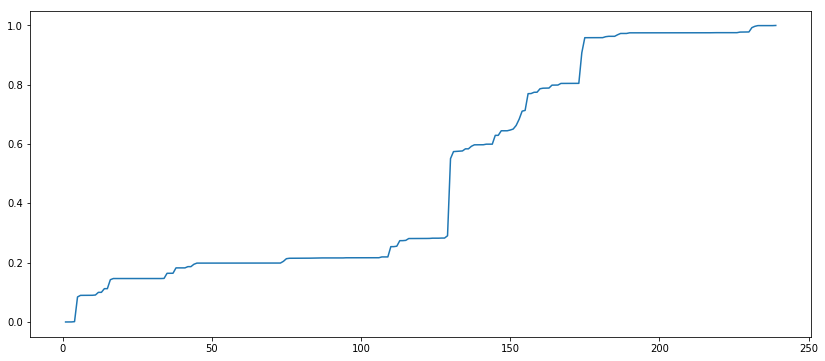

In [55]:
plt.plot(minute_data['minute_bars'], minute_data[ 'accum_pct' ])
plt.show

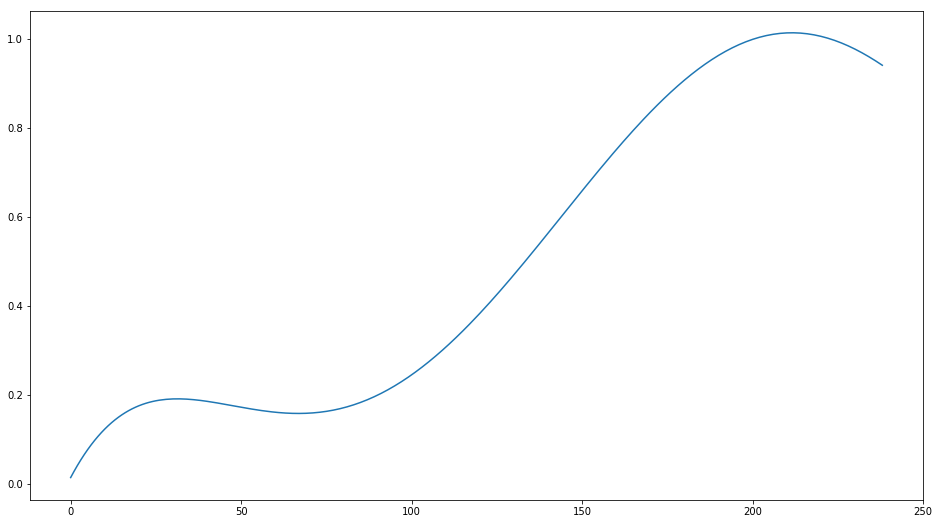

In [56]:
fig, ax1 = plt.subplots(figsize=(16,9))
plt.plot(predictions)

In [57]:
# or is there something about this that keeps it from getting to 1.0 that I'm forgetting?
minute_data.index

DatetimeIndex(['2019-05-01 07:01:00', '2019-05-01 07:02:00',
               '2019-05-01 07:03:00', '2019-05-01 07:04:00',
               '2019-05-01 07:05:00', '2019-05-01 07:06:00',
               '2019-05-01 07:07:00', '2019-05-01 07:08:00',
               '2019-05-01 07:09:00', '2019-05-01 07:10:00',
               ...
               '2019-05-01 10:50:00', '2019-05-01 10:51:00',
               '2019-05-01 10:52:00', '2019-05-01 10:53:00',
               '2019-05-01 10:54:00', '2019-05-01 10:55:00',
               '2019-05-01 10:56:00', '2019-05-01 10:57:00',
               '2019-05-01 10:58:00', '2019-05-01 10:59:00'],
              dtype='datetime64[ns]', name='date', length=239, freq='T')

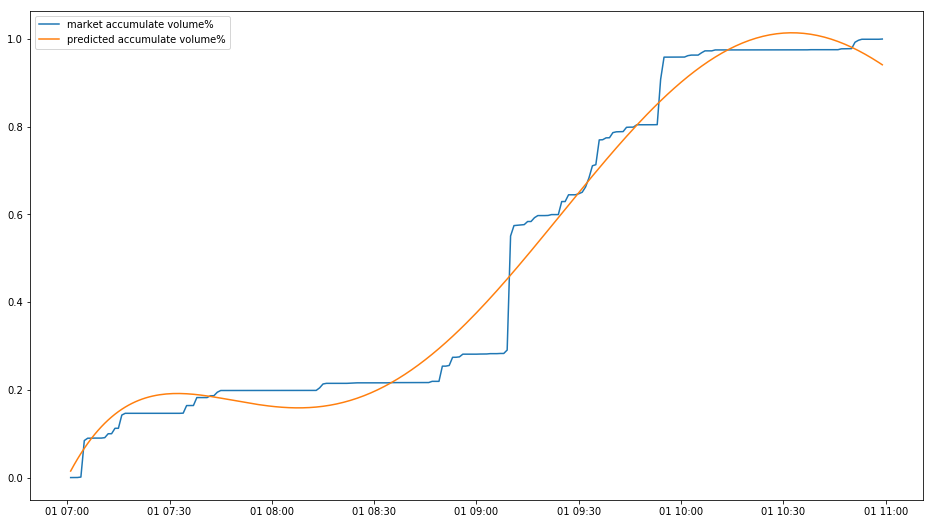

In [58]:

fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( minute_data[ 'accum_pct' ] , label = 'market accumulate volume%')
tgtsSeries = pd.Series( predictions )
tgtsSeries.index = minute_data.index
ax1.plot( tgtsSeries, label = 'predicted accumulate volume%')
plt.legend()
plt.show()

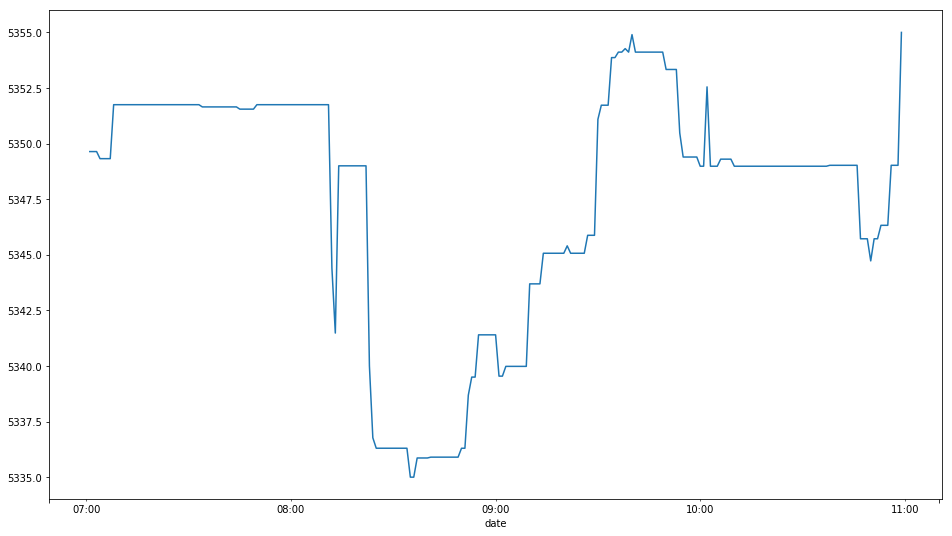

In [59]:
minute_data['close'].plot(figsize=(16,9))

### run a VWAP Algo with test data

In [60]:
len(predictions)

239

In [61]:
# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size ):
    bar_pcts = predictions
    bar_pcts = bar_pcts / predictions[ -1]
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( 'float' ), order_size )

In [62]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity )

In [63]:
len(order_targets)

239

In [64]:
order_targets[238]

5.0

In [65]:
trade_start_hour2

8

start loop : 2019-05-03 11:28:09:348825
end loop : 2019-05-03 11:28:09:442811
Btc volume: 81.80043982000007
order shares traded: 5.0
average price: 5424.946532540883
%trading_related_cost:0.21%
average trade size: 0.1388888888888889


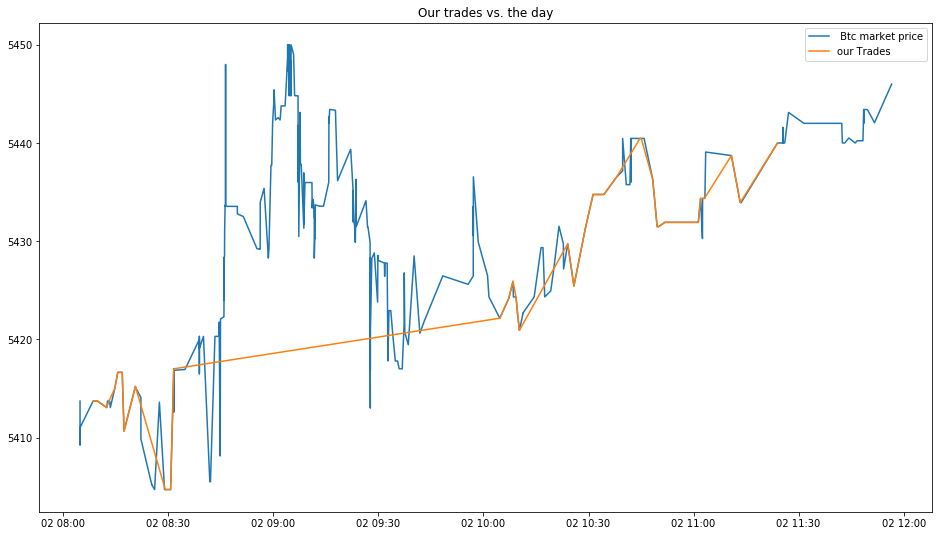

In [66]:
# initialize some other variables
current_bar = 1
current_target = 0
quantity_filled = 0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0
trades_arr = []
average_trades_price = 0
n = 1
trades_amount = 0
quantity_remaining = order_quantity
quantity_filled = 0
trading_related_cost = 0
# main event loop
show_time( 'start loop' )
for index, row in daytrades2.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = trade_start_hour2, minutes = start_minute2 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    last_price = row[ 'trade_price' ]
    last_quantity = row[ 'trade_qty' ]
        
    # collect volume
    total_volume += last_quantity
   
    # are we in a new minute?
    if ( minutes_from_open > current_bar ) and (current_bar < len(order_targets)):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
        # trade logic
        quantity_behind = current_target - quantity_filled
        if ( quantity_behind > 0 ): # we need to trade now
            new_trade_price = last_price
            new_trade_quantity = min(quantity_behind, last_quantity)
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
            
            # update quantity remaining
            quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity
            arrival_price = trades_arr[0][0]
            trading_related_cost += new_trade_quantity * (new_trade_price - arrival_price)
        
# looping done
show_time( 'end loop' )
#Now, let's look at some stats
        
trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )
print( 'Btc volume: ' + str( total_volume ) )
print( 'order shares traded: ' + str( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
trading_related_cost_pct = round(trading_related_cost / (order_quantity * arrival_price) * 100, 2)
print( 'average price: ' + str( avg_price ) )
print('%trading_related_cost:' + str(trading_related_cost_pct) + '%')
print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( daytrades2[ 'trade_price' ], label = ' Btc market price' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()
plt.show()



In [67]:
trading_fee_pct = 0.2
trading_cost_pct = trading_fee_pct + trading_related_cost_pct

## Moving Average Margin Trade Strategy

### calculate EMA

In [68]:

ema = []
for j in range(1, 20):
    ema.append(MarketChart['close'].ewm(span = 10 * j).mean())


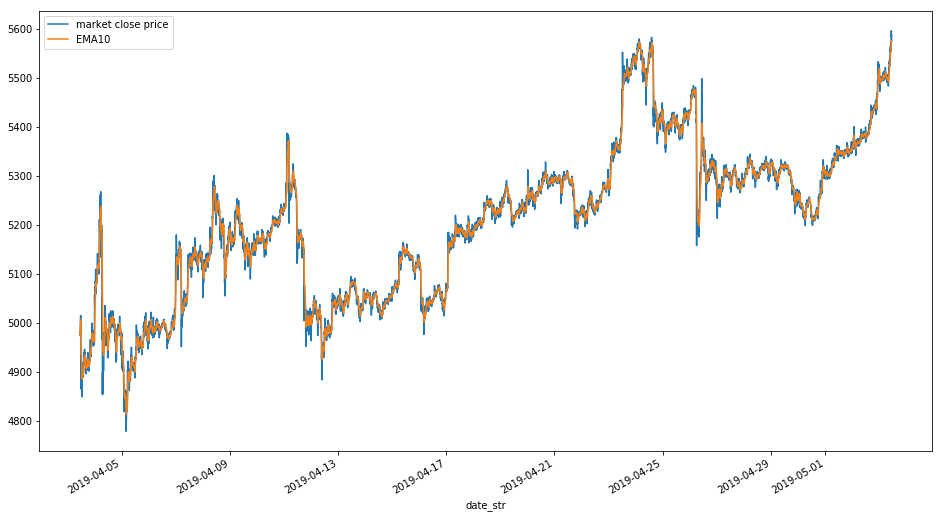

In [69]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
plt.plot(MarketChart.index, ema[0], label = 'EMA10')
plt.legend()
plt.show()

### calculate the difference pecentage between close and ema

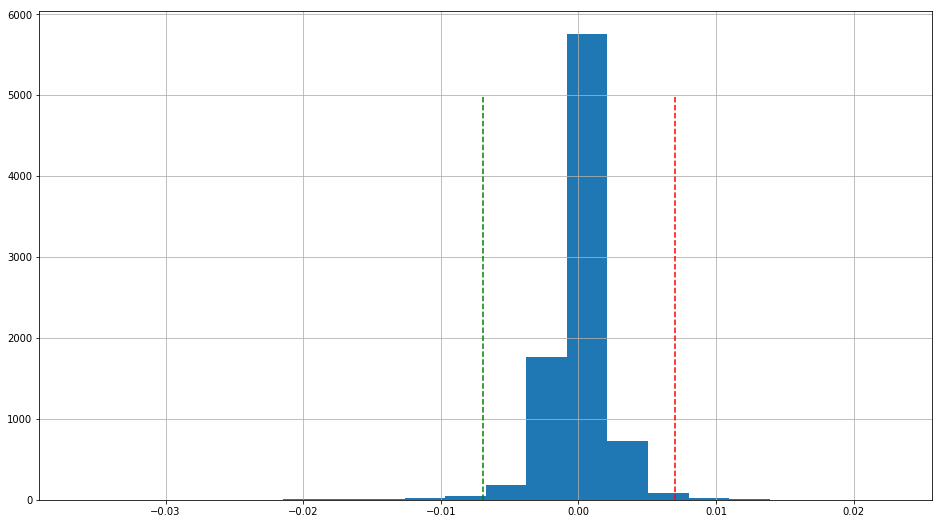

j=0 diff_pct_close_vs_ema_negative_abnormal: -0.007 diff_pct_close_vs_ema_min: -0.036 diff_pct_close_vs_ema_max:0.023 diff_pct_close_vs_ema_positive_abnormal: 0.007


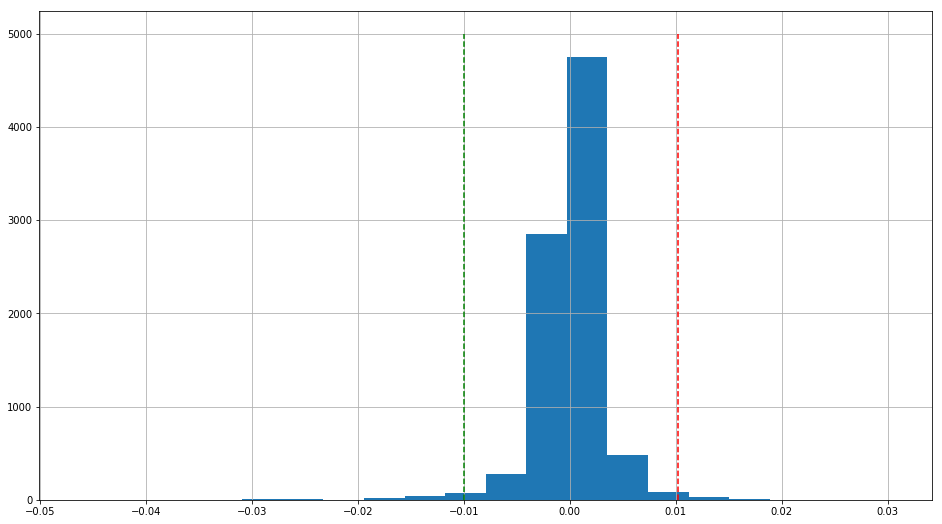

j=1 diff_pct_close_vs_ema_negative_abnormal: -0.010 diff_pct_close_vs_ema_min: -0.046 diff_pct_close_vs_ema_max:0.030 diff_pct_close_vs_ema_positive_abnormal: 0.010


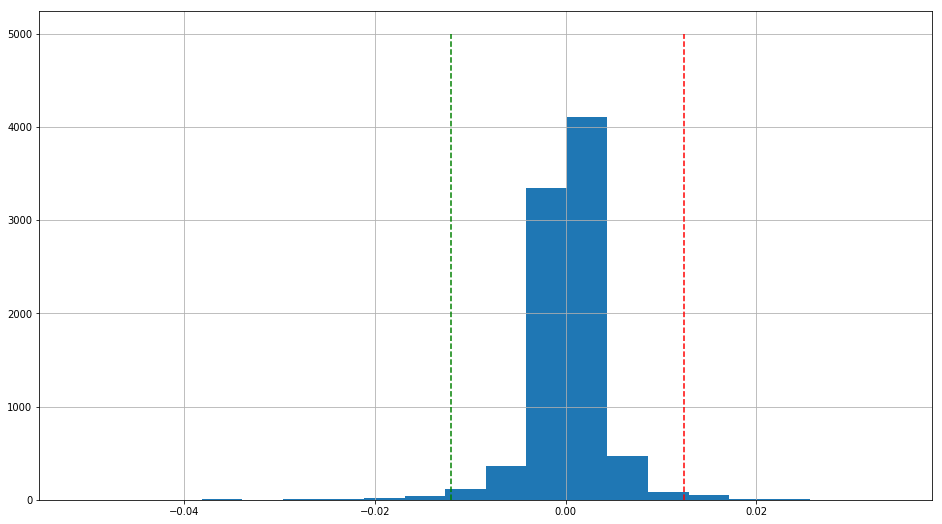

j=2 diff_pct_close_vs_ema_negative_abnormal: -0.012 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.034 diff_pct_close_vs_ema_positive_abnormal: 0.012


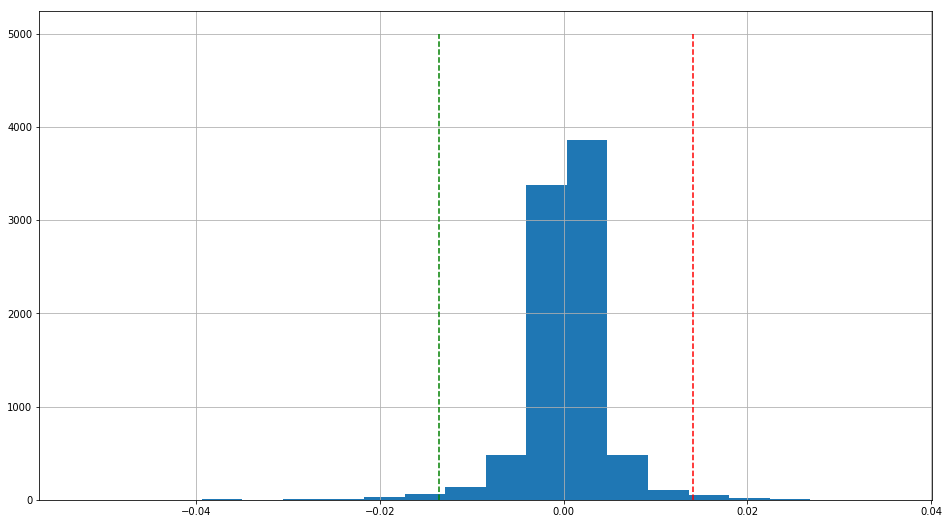

j=3 diff_pct_close_vs_ema_negative_abnormal: -0.014 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.036 diff_pct_close_vs_ema_positive_abnormal: 0.014


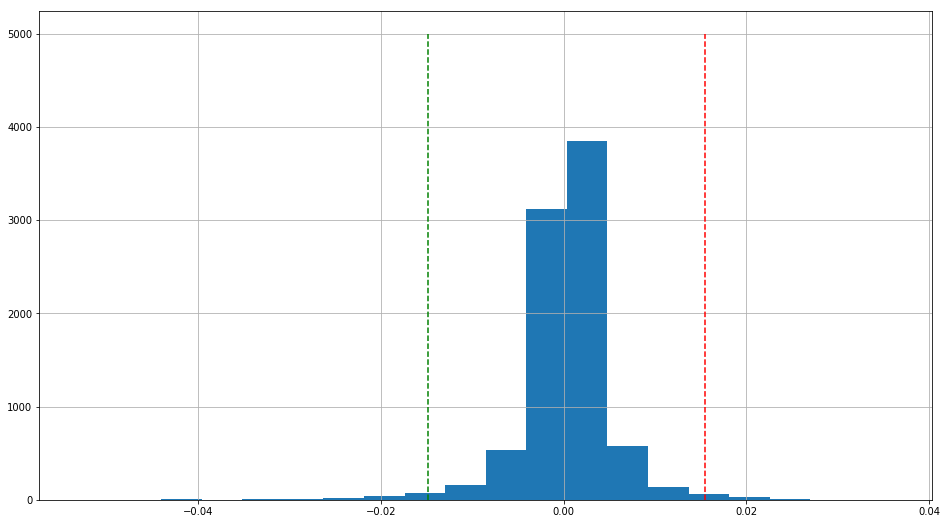

j=4 diff_pct_close_vs_ema_negative_abnormal: -0.015 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.036 diff_pct_close_vs_ema_positive_abnormal: 0.016


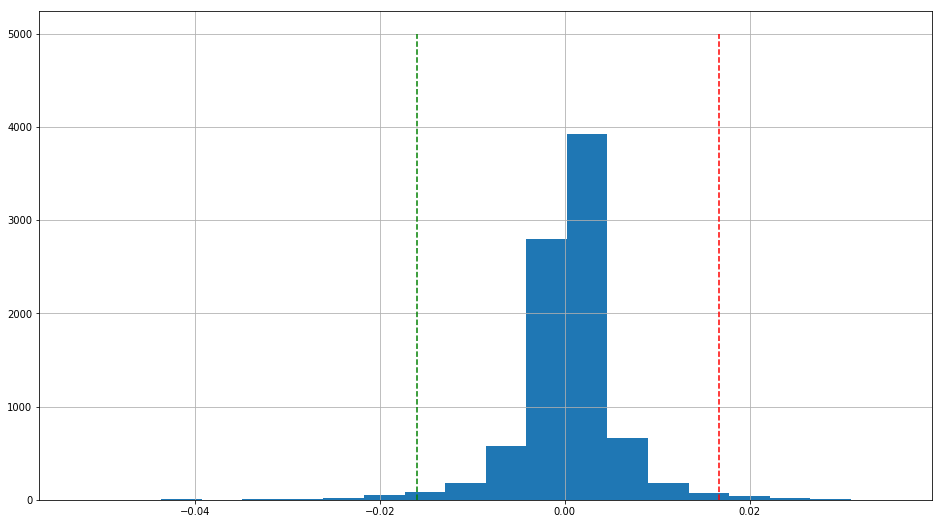

j=5 diff_pct_close_vs_ema_negative_abnormal: -0.016 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.035 diff_pct_close_vs_ema_positive_abnormal: 0.017


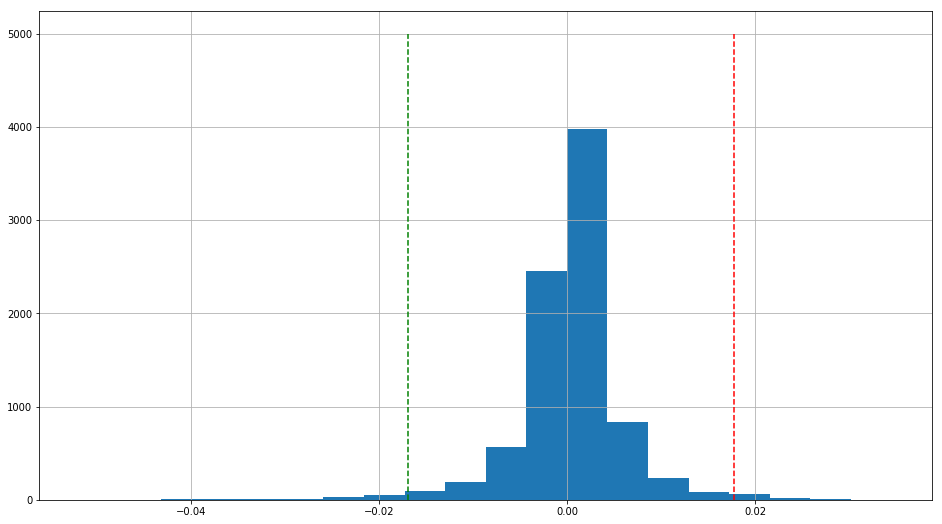

j=6 diff_pct_close_vs_ema_negative_abnormal: -0.017 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.035 diff_pct_close_vs_ema_positive_abnormal: 0.018


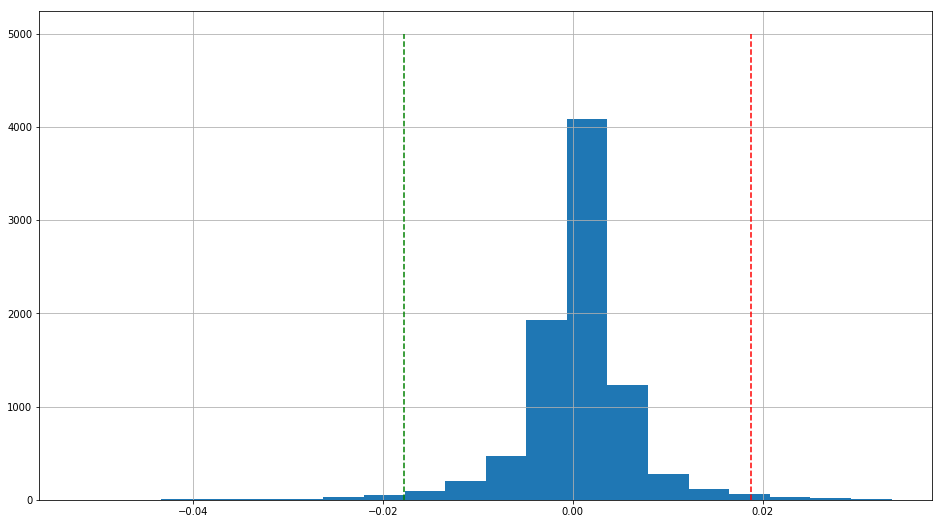

j=7 diff_pct_close_vs_ema_negative_abnormal: -0.018 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.034 diff_pct_close_vs_ema_positive_abnormal: 0.019


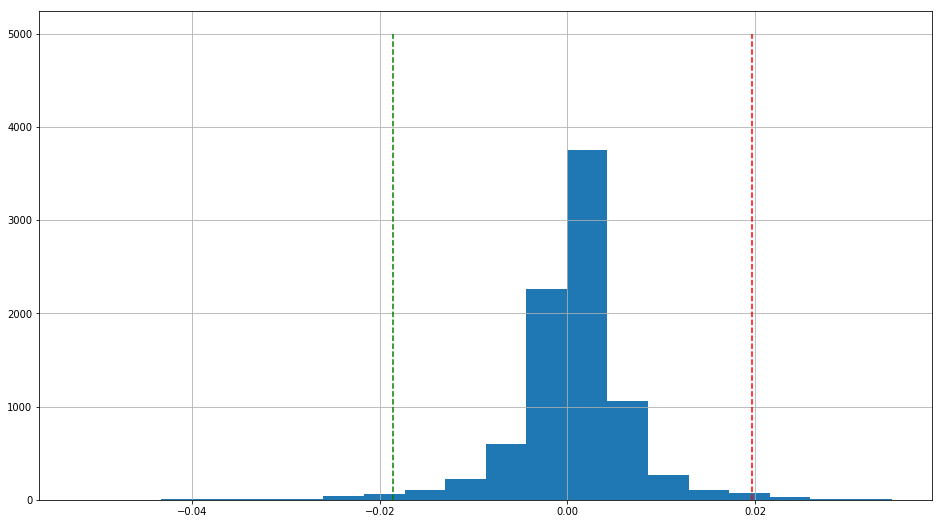

j=8 diff_pct_close_vs_ema_negative_abnormal: -0.019 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.035 diff_pct_close_vs_ema_positive_abnormal: 0.020


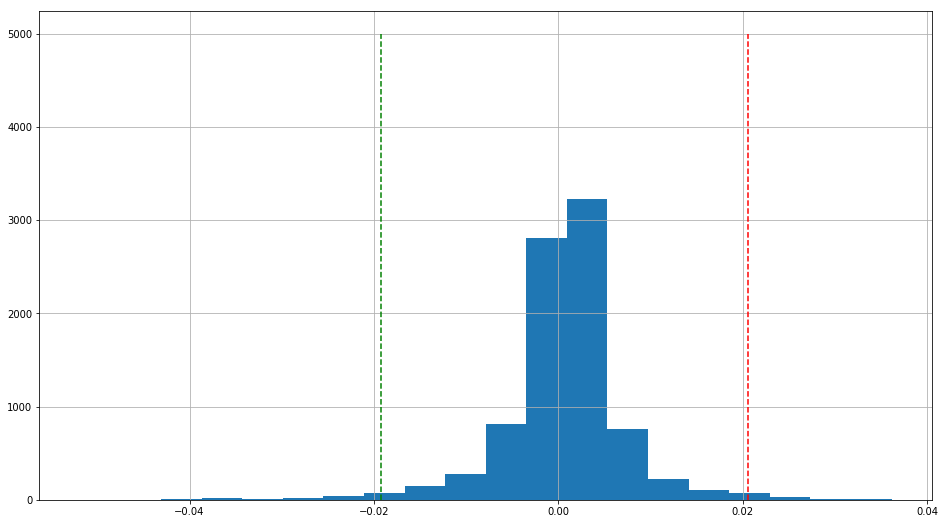

j=9 diff_pct_close_vs_ema_negative_abnormal: -0.019 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.036 diff_pct_close_vs_ema_positive_abnormal: 0.021


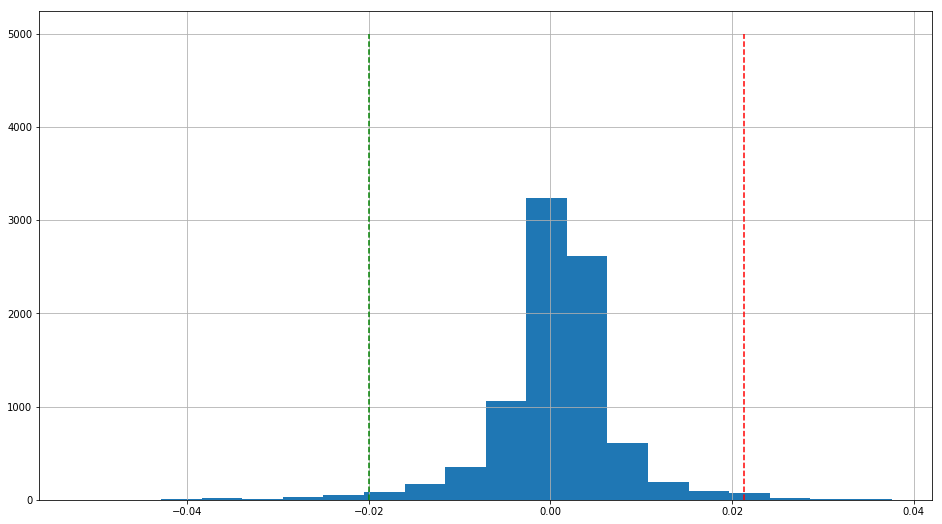

j=10 diff_pct_close_vs_ema_negative_abnormal: -0.020 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.038 diff_pct_close_vs_ema_positive_abnormal: 0.021


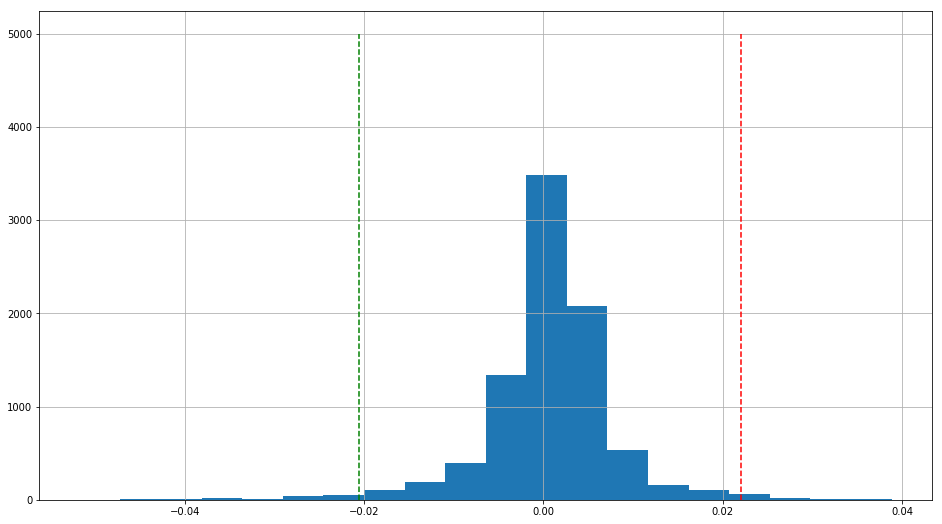

j=11 diff_pct_close_vs_ema_negative_abnormal: -0.021 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.039 diff_pct_close_vs_ema_positive_abnormal: 0.022


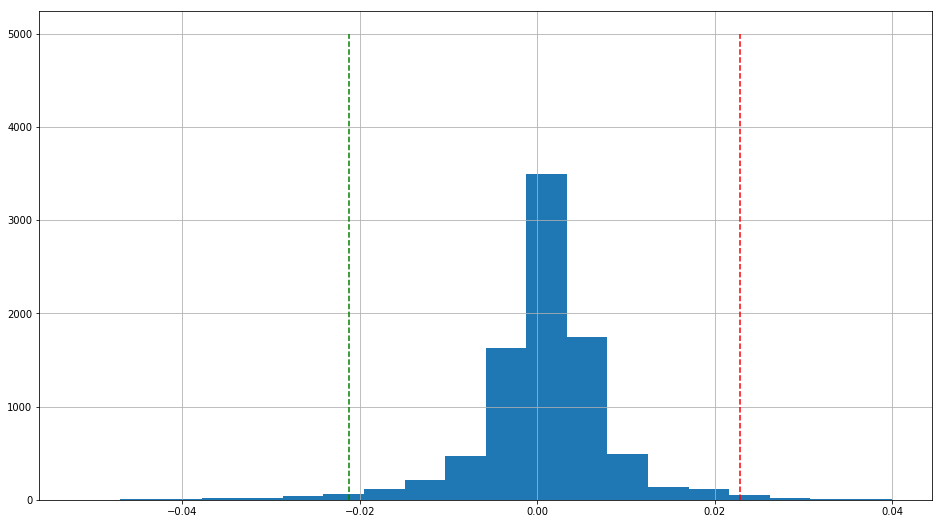

j=12 diff_pct_close_vs_ema_negative_abnormal: -0.021 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.040 diff_pct_close_vs_ema_positive_abnormal: 0.023


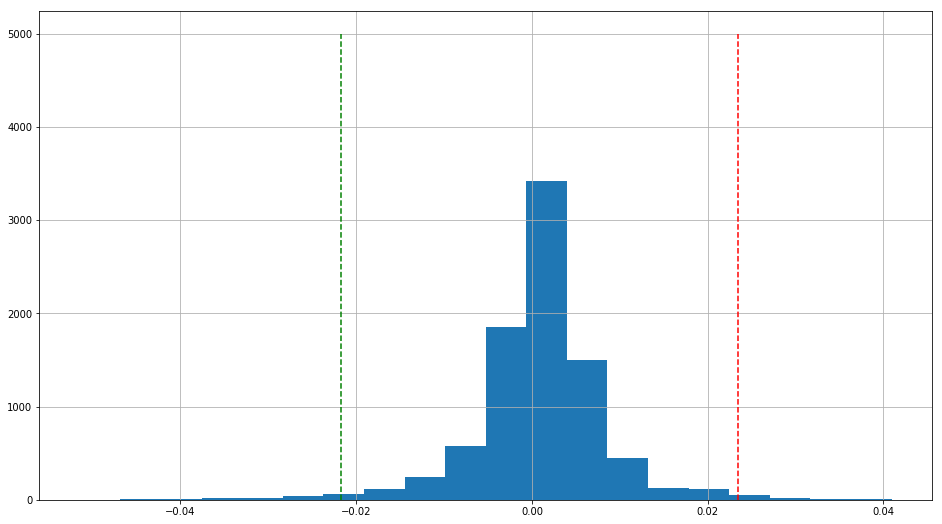

j=13 diff_pct_close_vs_ema_negative_abnormal: -0.022 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.041 diff_pct_close_vs_ema_positive_abnormal: 0.023


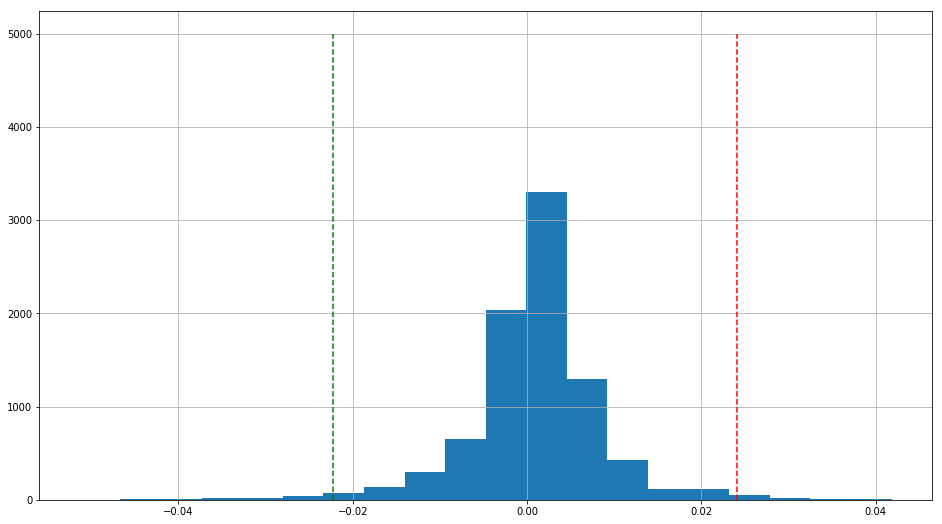

j=14 diff_pct_close_vs_ema_negative_abnormal: -0.022 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.042 diff_pct_close_vs_ema_positive_abnormal: 0.024


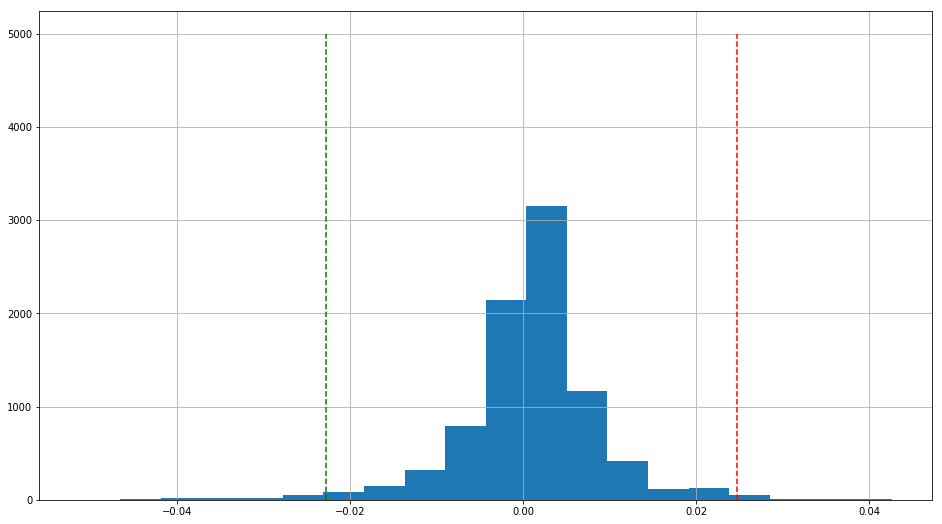

j=15 diff_pct_close_vs_ema_negative_abnormal: -0.023 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.043 diff_pct_close_vs_ema_positive_abnormal: 0.025


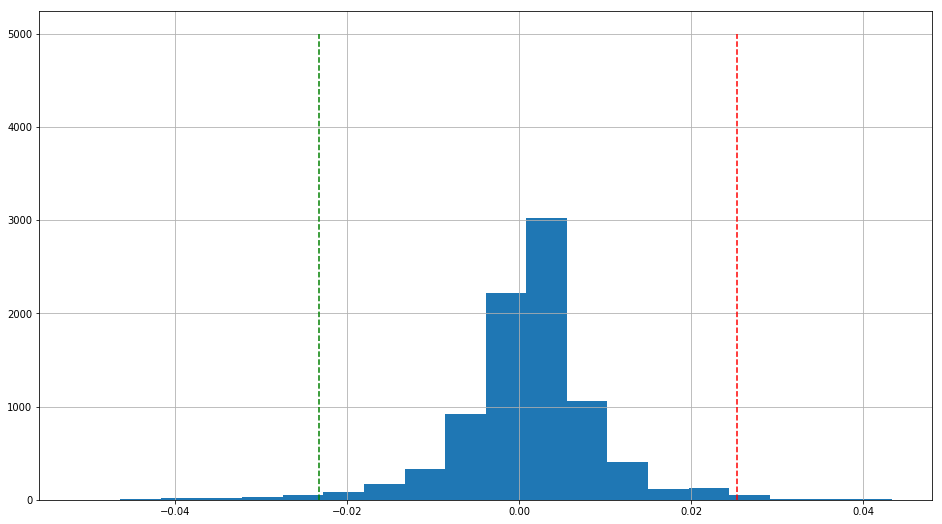

j=16 diff_pct_close_vs_ema_negative_abnormal: -0.023 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.043 diff_pct_close_vs_ema_positive_abnormal: 0.025


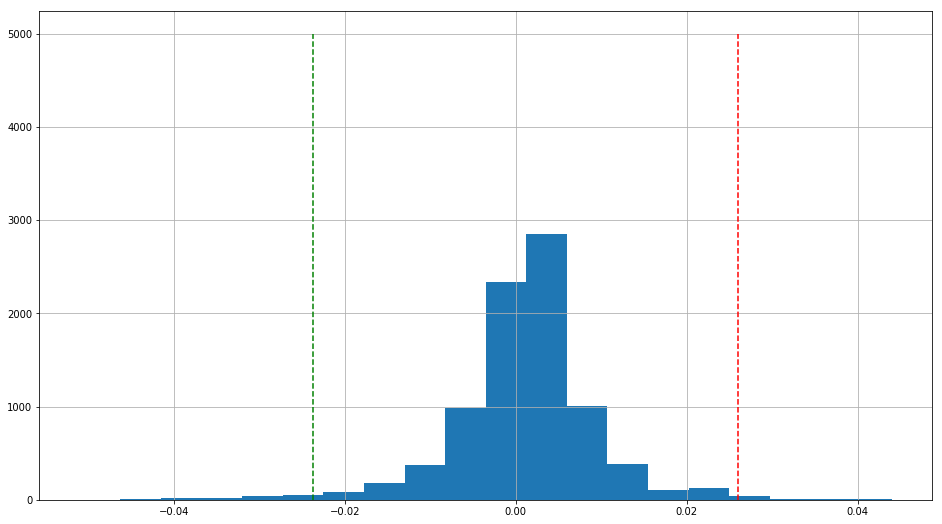

j=17 diff_pct_close_vs_ema_negative_abnormal: -0.024 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.044 diff_pct_close_vs_ema_positive_abnormal: 0.026


In [75]:


diff_pct_close_vs_ema = []
diff_pct_close_vs_ema_mean = []
diff_pct_close_vs_ema_std = []
diff_pct_close_vs_ema_negative_abnormal = []
diff_pct_close_vs_ema_positive_abnormal = []
diff_pct_close_vs_ema_max = []
diff_pct_close_vs_ema_min = []
for j in range(18):
    diff_pct_close_vs_ema.append((MarketChart['close'] - ema[j])/ ema[j])
    diff_pct_close_vs_ema_mean.append(diff_pct_close_vs_ema[j].mean())
    diff_pct_close_vs_ema_std.append(diff_pct_close_vs_ema[j].std())
    diff_pct_close_vs_ema_negative_abnormal.append(diff_pct_close_vs_ema_mean[j] - 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_positive_abnormal.append(diff_pct_close_vs_ema_mean[j] + 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_max.append(diff_pct_close_vs_ema[j].max())
    diff_pct_close_vs_ema_min.append(diff_pct_close_vs_ema[j].min())
    diff_pct_close_vs_ema[j].hist(bins=20,figsize=(16,9))
    plt.vlines(diff_pct_close_vs_ema_negative_abnormal[j], 0, 5000, colors = "green", linestyles = "dashed")
    plt.vlines(diff_pct_close_vs_ema_positive_abnormal[j], 0, 5000, colors = "red", linestyles = "dashed")
    plt.show()
    print('j={0} diff_pct_close_vs_ema_negative_abnormal: {1:.3f} diff_pct_close_vs_ema_min: {2:.3f} diff_pct_close_vs_ema_max:{3:.3f} diff_pct_close_vs_ema_positive_abnormal: {4:.3f}'.format(j, diff_pct_close_vs_ema_negative_abnormal[j], diff_pct_close_vs_ema_min[j], diff_pct_close_vs_ema_max[j], diff_pct_close_vs_ema_positive_abnormal[j]))

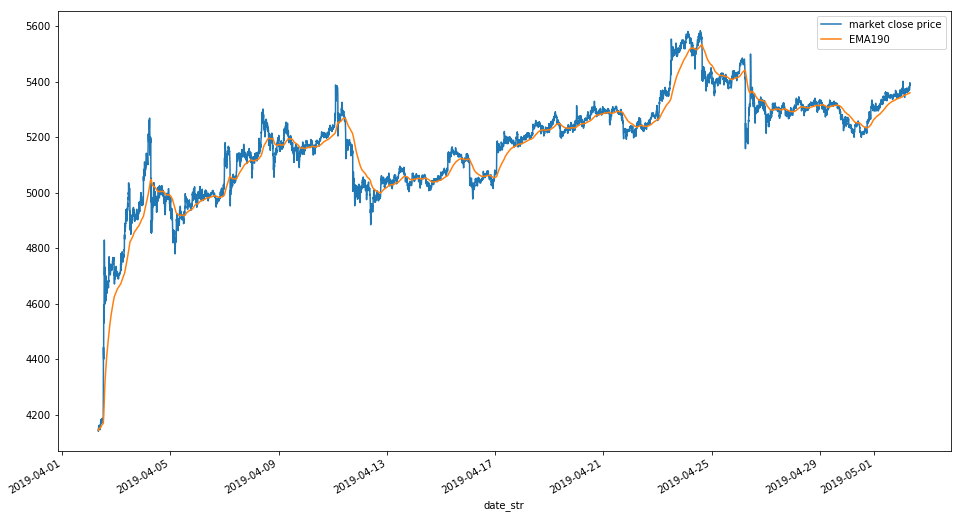

In [208]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
plt.plot(MarketChart.index, ema[18], label = 'EMA190')
plt.legend()
plt.show()

### select j and span

In [201]:
## calculate market 5 minute return
start = MarketChart_datetime[0]
end = MarketChart_datetime[- 1]
days = (end - start).days
performance = {'j':[], 'strategy_annual_return':[], 'strategy_annual_std':[], 'strategy_annual_sharpe':[], 'win_rate':[], 'final_pnl':[]}
principle_dict = {'j':[], 'index':[], 'principle':[]}
sig_buy_list = []
sig_sell_list = []
signal_list = []
strategy_return_list = []
strategy_capital_line = []
strategy_std = []
strategy_sharpe = []
trade_price_dict ={'j':[], 'index':[], 'trade_price':[]}
for j in range(18):
    ## setup signal
    sig_buy = ma.ceil(diff_pct_close_vs_ema_negative_abnormal[j] * 1000) / 1000
    sig_buy_list.append(sig_buy)
    sig_sell = ma.floor(diff_pct_close_vs_ema_positive_abnormal[j] * 1000) / 1000
    sig_sell_list.append(sig_sell)
    index_stock_price = 1
    n_stock_price = len(MarketChart)
    sig = np.zeros(n_stock_price, dtype = np.int)
   
    for index_stock_price in range(n_stock_price):
        if diff_pct_close_vs_ema[j][index_stock_price - 1] <  sig_buy:
            sig[index_stock_price] = 1
        elif diff_pct_close_vs_ema[j][index_stock_price - 1] >= sig_sell:
            sig[index_stock_price] = - 1
        else:
            if sig[index_stock_price - 1] == 1:
                sig[index_stock_price] = 1
            elif sig[index_stock_price - 1] == 0:
                sig[index_stock_price] = 0
            elif sig[index_stock_price - 1] == - 1:
                sig[index_stock_price] = - 1
    signal = pd.Series(sig, index = MarketChart.index)
    signal_list.append(signal)
    
    
    # now let's accumulate some P&L
    position = 0
    principle = order_quantity * MarketChart.iloc[0, 0]
    
    #leverage = 1
    pnl = 0
    previous_signal = 0
    start_price = 0
    negative_pnl = 0
    positive_pnl = 0
    for index, row in MarketChart.iterrows():
        current_signal = signal.loc[index]
        if current_signal != previous_signal: # we need to do a trade
            # first check if we have an open position
            if position != 0: 
                # first we need to close the position and calculate P&L
                trade_price_dict['j'].append(j)
                trade_price_dict['index'].append(index)
                trade_price_dict['trade_price'].append(row['open'] * (1 - trading_cost_pct / 100))
                current_pnl = position * (row['open'] * (1 - trading_cost_pct / 100) - start_price)
                if position < 0:
                    principle = start_principle + current_pnl
                else:
                    principle = trade_size * row['open'] * (1 - trading_cost_pct / 100)
                principle_dict['j'].append(j)
                principle_dict['index'].append(index)
                principle_dict['principle'].append(principle)
                if current_pnl < 0:
                    negative_pnl += 1
                else:
                    positive_pnl += 1
                pnl += current_pnl
            
            # now open a new position
           
            trade_size = principle * (1 - trading_cost_pct / 100) / row['open'] 
            position = trade_size * current_signal # buy if signal is positive, sell if signal is negative
            start_price = row['open'] * (1+ trading_cost_pct / 100)
            start_principle = principle * (1 - trading_cost_pct / 100)
            principle_dict['j'].append(j)
            principle_dict['index'].append(index)
            principle_dict['principle'].append(start_principle)
            trade_price_dict['j'].append(j)
            trade_price_dict['index'].append(index)
            trade_price_dict['trade_price'].append(start_price)
            previous_signal = current_signal
        else:
            if position > 0:
                principle = trade_size * row['close']
                principle_dict['j'].append(j)
                principle_dict['index'].append(index)
                principle_dict['principle'].append(principle)
            elif position < 0:
                current_pnl = position * (row['close'] -  start_price)
                principle = start_principle + current_pnl
                principle_dict['j'].append(j)
                principle_dict['index'].append(index)
                principle_dict['principle'].append(principle)
            else:
                principle_dict['j'].append(j)
                principle_dict['index'].append(index)
                principle_dict['principle'].append(principle)

    win_rate = positive_pnl / (positive_pnl + negative_pnl) * 100
    performance['j'].append(j) 
    performance['win_rate'].append(win_rate)
    
    ## calculate strategy 5 minute return
    principle_df = pd.DataFrame(principle_dict)
    strategy_return = (principle_df[principle_df['j'] == j]['principle'] - principle_df[principle_df['j'] == j]['principle'].shift(1)) /  principle_df[principle_df['j'] == j]['principle'].shift(1)
    strategy_return1 = strategy_return.dropna()
    strategy_return2 = list(strategy_return1)
    strategy_return_list.append(strategy_return1)
    
    # calculate strategy annual return
    strategy_accumulate_return= np.cumprod(1 + np.array(strategy_return2)).tolist()
    strategy_capital_line.append(strategy_accumulate_return)
    strategy_annual_return = ma.pow(strategy_accumulate_return[-1] / strategy_accumulate_return[0], 365/days ) -1
    performance['strategy_annual_return'].append(strategy_annual_return)
    
    # calculate stragegy 5 minute standard deviation
    strategy_std.append(stat.stdev(strategy_return_list[j]))
    
    #  calculate strategy annual standard deviation
    performance['strategy_annual_std'].append(strategy_std[j] * ma.sqrt(365 * 24 * 12))

    # calculate strategy sharpe ratio
    performance['strategy_annual_sharpe'].append((performance['strategy_annual_return'][j] - 0.02) / performance['strategy_annual_std'][j])
    
    performance['final_pnl'].append(pnl)


In [125]:
## when final_pnl is the max
performance_df = pd.DataFrame(performance)
best_j = performance_df.index.values[performance_df['strategy_annual_sharpe'] == performance_df['strategy_annual_sharpe'].max()]
best_j

array([14])

In [132]:
best_j[0]

14

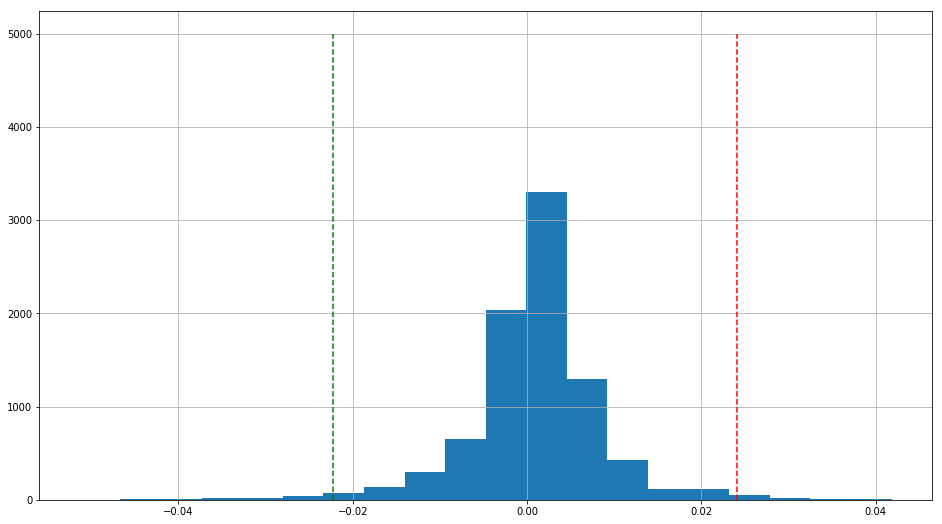

j=14 diff_pct_close_vs_ema_negative_abnormal: -0.022 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.042 diff_pct_close_vs_ema_positive_abnormal: 0.024


In [264]:
diff_pct_close_vs_ema[best_j[0]].hist(bins=20,figsize=(16,9))
plt.vlines(diff_pct_close_vs_ema_negative_abnormal[best_j[0]], 0, 5000, colors = "green", linestyles = "dashed")
plt.vlines(diff_pct_close_vs_ema_positive_abnormal[best_j[0]], 0, 5000, colors = "red", linestyles = "dashed")
plt.show()
print('j={0} diff_pct_close_vs_ema_negative_abnormal: {1:.3f} diff_pct_close_vs_ema_min: {2:.3f} diff_pct_close_vs_ema_max:{3:.3f} diff_pct_close_vs_ema_positive_abnormal: {4:.3f}'.format(best_j[0], diff_pct_close_vs_ema_negative_abnormal[best_j[0]], diff_pct_close_vs_ema_min[best_j[0]], diff_pct_close_vs_ema_max[best_j[0]], diff_pct_close_vs_ema_positive_abnormal[best_j[0]]))

In [159]:
performance_df.iloc[best_j[0]]

j                            14.000000
strategy_annual_return      172.285923
strategy_annual_std           0.582443
strategy_annual_sharpe      295.764421
win_rate                    100.000000
final_pnl                 13815.031141
Name: 14, dtype: float64

In [191]:
MarketChart_return = (MarketChart - MarketChart.shift(1))/MarketChart.shift(1)
MarketChart_return= MarketChart_return.dropna()
MarketChart_return2 = MarketChart_return['close']
MarketChart_std = MarketChart_return2.std()
MarketChart_annual_std = MarketChart_std * ma.sqrt(365 * 24 * 12)
MarketChart_datetime = MarketChart.index.to_pydatetime()

MarketChart_return3 = list(MarketChart_return2)
MarketChart_capital_line = np.cumprod(1 + np.array(MarketChart_return2))
MarketChart_capital_line_list = MarketChart_capital_line.tolist()
MarketChart_annual_return = ma.pow(MarketChart_capital_line_list[-1] / MarketChart_capital_line_list[0], 365/days ) -1
MarketChart_annual_sharpe = (MarketChart_annual_return - 0.02) / MarketChart_annual_std

In [113]:
## select min period of trading
signal_best = pd.Series(signal_list[best_j[0]])

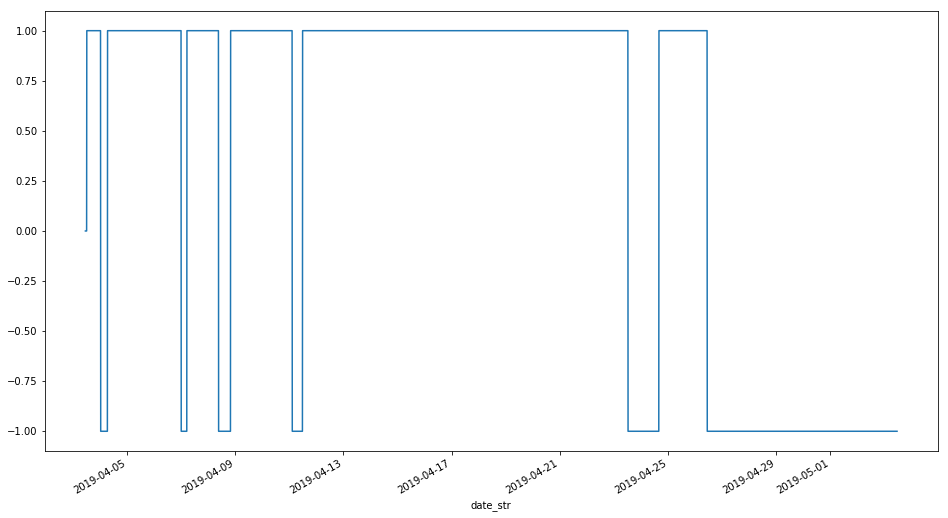

In [114]:
signal_best.plot(figsize=(16,9))

In [117]:
trade_price_df = pd.DataFrame(trade_price_dict)

In [118]:
trade_price_df_best = trade_price_df[trade_price_df['j']== best_j[0]]

In [119]:
trade_price_df_best.set_index(keys = 'index', inplace = True)

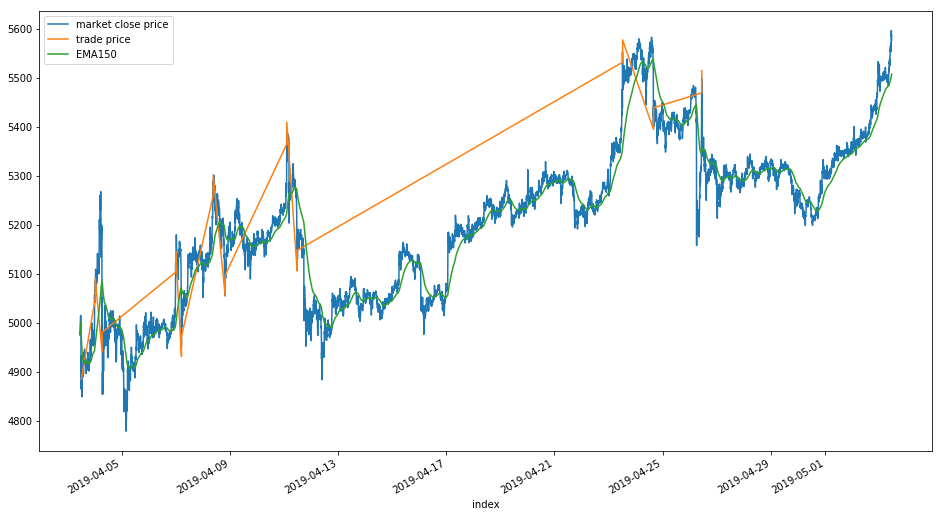

In [120]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
trade_price_df_best['trade_price'].plot(figsize=(16,9), label = 'trade price')
plt.plot(MarketChart.index, ema[best_j[0]], label = 'EMA150')
plt.legend()
plt.show()

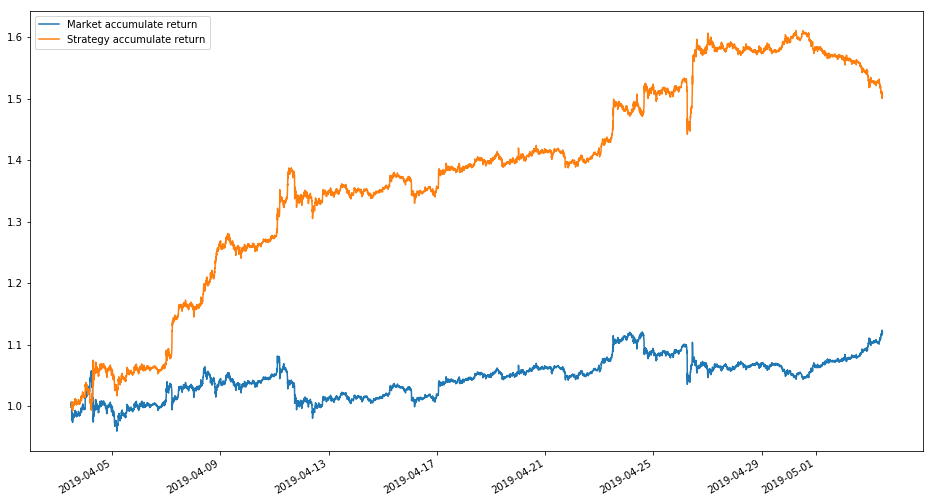

In [229]:
MarketChart_capital_line_df = pd.DataFrame(MarketChart_capital_line)
MarketChart_capital_line_df.index = MarketChart_return2.index
strategy_capital_line_best = pd.DataFrame(strategy_capital_line[best_j[0]])
principle_df_best1 = principle_df_best.shift(1)
principle_df_best1 = principle_df_best1.dropna()
strategy_capital_line_best.index = principle_df_best1.index
MarketChart_capital_line_and_strategy_capital_line_best = pd.merge(MarketChart_capital_line_df, strategy_capital_line_best, left_index = True, right_index = True)
MarketChart_capital_line_and_strategy_capital_line_best.columns = ['Market accumulate return', 'Strategy accumulate return']

MarketChart_capital_line_and_strategy_capital_line_best.plot(figsize=(16,9))
plt.legend()
plt.show()

In [236]:
performance_btc = ['Btc', MarketChart_annual_return, MarketChart_annual_std, MarketChart_annual_sharpe ]
performance_strategy = ['EMA Strategy Margin Trade', performance_df.loc[best_j[0], 'strategy_annual_return'], performance_df.loc[best_j[0], 'strategy_annual_std'], performance_df.loc[best_j[0], 'strategy_annual_sharpe']]

MarketChart_and_strategy_return_and_risk = pd.DataFrame([performance_btc, performance_strategy])
MarketChart_and_strategy_return_and_risk.columns = ['project', 'annual_return', 'annual_std', 'annual_sharpe']

In [237]:
MarketChart_and_strategy_return_and_risk

,project,annual_return,annual_std,annual_sharpe
0,Btc,3.209546,0.588419,5.420533
1,EMA Strategy Margin Trade,172.285923,0.582443,295.764421


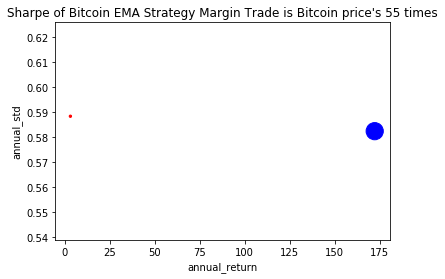

In [249]:
size = MarketChart_and_strategy_return_and_risk['annual_sharpe'].rank()
n = 400
color = {0: 'red', 1:'blue'}
plt.scatter(MarketChart_and_strategy_return_and_risk['annual_return'], MarketChart_and_strategy_return_and_risk['annual_std'], color =[color[i] for i in MarketChart_and_strategy_return_and_risk.index], s = MarketChart_and_strategy_return_and_risk['annual_sharpe'])
plt.xlabel('annual_return')
plt.ylabel('annual_std')
plt.title("Sharpe of Bitcoin EMA Strategy Margin Trade is Bitcoin price's 55 times")
plt.show()